In [6]:
%pip install pandas numpy matplotlib seaborn numba scikit-learn lightgbm folium shapely geopandas


  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------- ----------------- 1.6/2.8 MB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 8.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ----------- ---------------------------- 2.4/8.0 MB 12.2 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.0 MB 12.1 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.0 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 11.5 MB/s eta 0:00:00
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 10.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ?


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import seaborn as sns

import math
from numba import jit

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_absolute_error

import folium
from shapely.geometry import Polygon
import geopandas as gpd
import re
from ast import literal_eval

In [2]:
########## 5개년 사고 데이터 전처리 ########## 
# csv 파일 불러와 DataFrame으로 만들기
accident_2023 = pd.read_csv('data/rawdata/도로교통공단_사망교통사고정보_2023.csv', encoding='cp949')
accident_2022 = pd.read_csv('data/rawdata/도로교통공단_사망교통사고정보_2022.csv', encoding='cp949')
accident_2021 = pd.read_csv('data/rawdata/도로교통공단_사망교통사고정보_2021.csv', encoding='cp949')
accident_2020 = pd.read_csv('data/rawdata/도로교통공단_사망교통사고정보_2020.csv', encoding='cp949')
accident_2019 = pd.read_csv('data/rawdata/도로교통공단_사망교통사고정보_2019.csv', encoding='cp949')

print(accident_2023.columns)
print(accident_2022.columns)
print(accident_2021.columns)
print(accident_2020.columns)
print(accident_2019.columns)

Index(['발생년', '발생년월일시', '주야', '요일', '사망자수', '부상자수', '중상자수', '경상자수', '부상신고자수',
       '발생지시도', '발생지시군구', '사고유형_대분류', '사고유형_중분류', '사고유형', '가해자법규위반',
       '도로형태_대분류', '도로형태', '가해자_당사자종별', '피해자_당사자종별', '발생위치X', '발생위치Y', '경도',
       '위도'],
      dtype='object')
Index(['발생년', '발생년월일시', '주야', '요일', '사망자수', '부상자수', '중상자수', '경상자수', '부상신고자수',
       '발생지시도', '발생지시군구', '사고유형_대분류', '사고유형_중분류', '사고유형', '가해자법규위반',
       '도로형태_대분류', '도로형태', '가해자_당사자종별', '피해자_당사자종별', '발생위치X_UTMK',
       '발생위치Y_UTMK', '경도', '위도'],
      dtype='object')
Index(['발생년', '발생년월일시', '주야', '요일', '사망자수', '부상자수', '중상자수', '경상자수', '부상신고자수',
       '발생지시도', '발생지시군구', '사고유형_대분류', '사고유형_중분류', '사고유형', '가해자법규위반',
       '도로형태_대분류', '도로형태', '가해자_당사자종별', '피해자_당사자종별', '발생위치X(UTMK)',
       '발생위치Y(UTMK)', '경도', '위도'],
      dtype='object')
Index(['발생년', '발생년월일시', '주야', '요일', '사망자수', '부상자수', '중상자수', '경상자수', '부상신고자수',
       '발생지시도', '발생지시군구', '사고유형_대분류', '사고유형_중분류', '사고유형', '가해자법규위반',
       '도로형태_대분류', '도로형태', '가해자_당사자종별', '피해자_당사자종별'

In [3]:
# column 이름 한 종류로 통일하기
column_names = accident_2019.columns

accident_2019.columns = column_names
accident_2020.columns = column_names
accident_2021.columns = column_names
accident_2022.columns = column_names
accident_2023.columns = column_names

In [4]:
#5개 데이터 합치기
accident = pd.concat([accident_2019, accident_2020, accident_2021, accident_2022, accident_2023])
accident = accident.reset_index(drop=True)

In [5]:
accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14158 entries, 0 to 14157
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   발생년         14158 non-null  int64  
 1   발생년월일시      14158 non-null  object 
 2   주야          14158 non-null  object 
 3   요일          14158 non-null  object 
 4   사망자수        14158 non-null  int64  
 5   부상자수        14158 non-null  int64  
 6   중상자수        14158 non-null  int64  
 7   경상자수        14158 non-null  int64  
 8   부상신고자수      14158 non-null  int64  
 9   발생지시도       14158 non-null  object 
 10  발생지시군구      14158 non-null  object 
 11  사고유형_대분류    14158 non-null  object 
 12  사고유형_중분류    14158 non-null  object 
 13  사고유형        14158 non-null  object 
 14  가해자법규위반     14158 non-null  object 
 15  도로형태_대분류    14158 non-null  object 
 16  도로형태        14158 non-null  object 
 17  가해자_당사자종별   14158 non-null  object 
 18  피해자_당사자종별   14158 non-null  object 
 19  발생위치X_UTMK  14158 non-nul

In [6]:
#결측치 확인하기
accident.isna().sum()

발생년           0
발생년월일시        0
주야            0
요일            0
사망자수          0
부상자수          0
중상자수          0
경상자수          0
부상신고자수        0
발생지시도         0
발생지시군구        0
사고유형_대분류      0
사고유형_중분류      0
사고유형          0
가해자법규위반       0
도로형태_대분류      0
도로형태          0
가해자_당사자종별     0
피해자_당사자종별     0
발생위치X_UTMK    0
발생위치Y_UTMK    0
경도            0
위도            0
dtype: int64

In [7]:
# 사용하지 않을 column 삭제하기
accident = accident.drop(columns=['부상자수','부상신고자수', '발생지시군구', '사고유형_중분류',
                                  '사고유형', '도로형태', '발생위치X_UTMK', '발생위치Y_UTMK'])

In [8]:
#사망자수, 중상자수, 경상자수 가중치 부여해 합쳐 '사상자수'라는 column으로(종속변수용)
accident['사상자수'] = accident['사망자수'] + accident['중상자수']*0.7 + accident['경상자수']*0.3
accident = accident.drop(columns=['사망자수','중상자수', '경상자수'])

In [9]:
# 발생년월일시 -> 발생월, 일, 시로 구분하기
accident['발생월'] = accident['발생년월일시'].apply(lambda x : int(x[5:7]))
accident['발생일'] = accident['발생년월일시'].apply(lambda x : int(x[8:10]))
accident['발생시'] = accident['발생년월일시'].apply(lambda x : int(x[11:13]))

accident = accident.drop(columns='발생년월일시')
display(accident.head())

,발생년,주야,요일,발생지시도,사고유형_대분류,가해자법규위반,도로형태_대분류,가해자_당사자종별,피해자_당사자종별,경도,위도,사상자수,발생월,발생일,발생시
0,2019,야,화,부산,차대사람,중앙선 침범,교차로,승용차,보행자,129.152465,35.157884,1.0,1,1,0
1,2019,야,화,경기,차대차,중앙선 침범,단일로,승용차,승용차,126.857149,37.288292,1.0,1,1,3
2,2019,주,화,경북,차대차,안전운전 의무 불이행,교차로,승용차,사륜오토바이(ATV),128.609230,35.650108,1.0,1,1,16
3,2019,야,화,대전,차대사람,안전운전 의무 불이행,교차로,승용차,보행자,127.379560,36.355946,1.0,1,1,19
4,2019,야,화,경북,차대사람,안전운전 의무 불이행,단일로,승용차,보행자,128.915041,35.899506,1.0,1,1,21


In [10]:
# column 순서 변경 후 시각화용 csv 파일로 저장하기
accident = accident[['발생년','발생월', '발생일', '발생시', '주야', '요일', '발생지시도', '사고유형_대분류',
            '가해자법규위반', '도로형태_대분류','가해자_당사자종별', '피해자_당사자종별', '경도', '위도', '사상자수']]
accident.to_csv('data/accident_for_visualization.csv', encoding='cp949', index=False)

In [11]:
########## 단속카메라 데이터 전처리 ##########
camera = pd.read_csv('data/rawdata/전국무인교통단속카메라표준데이터.csv', encoding='cp949')
camera = camera[['위도', '경도', '설치연도']]

In [12]:
# 단속카메라 데이터 결측치 확인하기
camera.isna().sum()

위도         8
경도         8
설치연도    3726
dtype: int64

In [13]:
# 단속카메라 데이터 결측치 제거하기
camera = camera.dropna(subset=['위도', '경도']).reset_index(drop=True)

<Axes: xlabel='경도', ylabel='위도'>

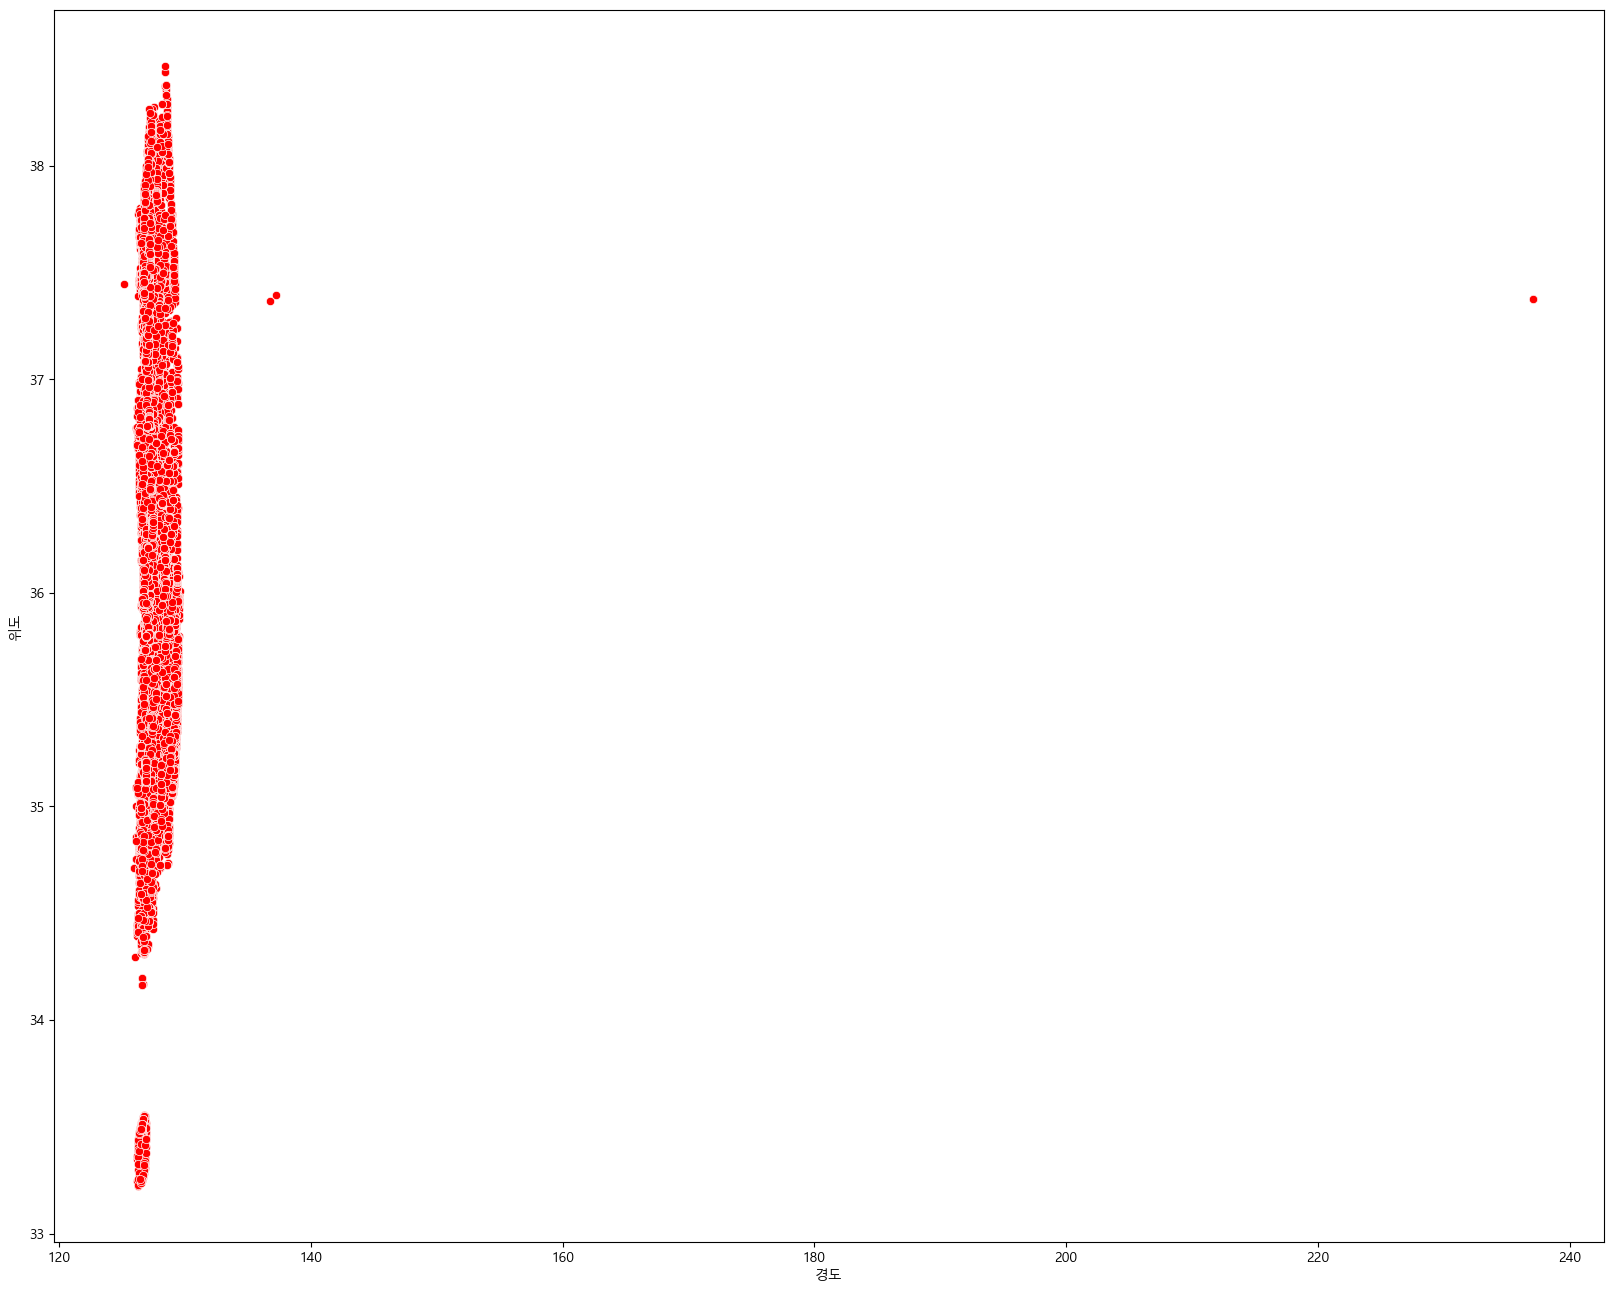

In [14]:
# 단속카메라 데이터 이상치 확인하기
plt.figure(figsize=(20, 16))
sns.scatterplot(camera, x='경도', y='위도', color='red')

<Axes: xlabel='경도', ylabel='위도'>

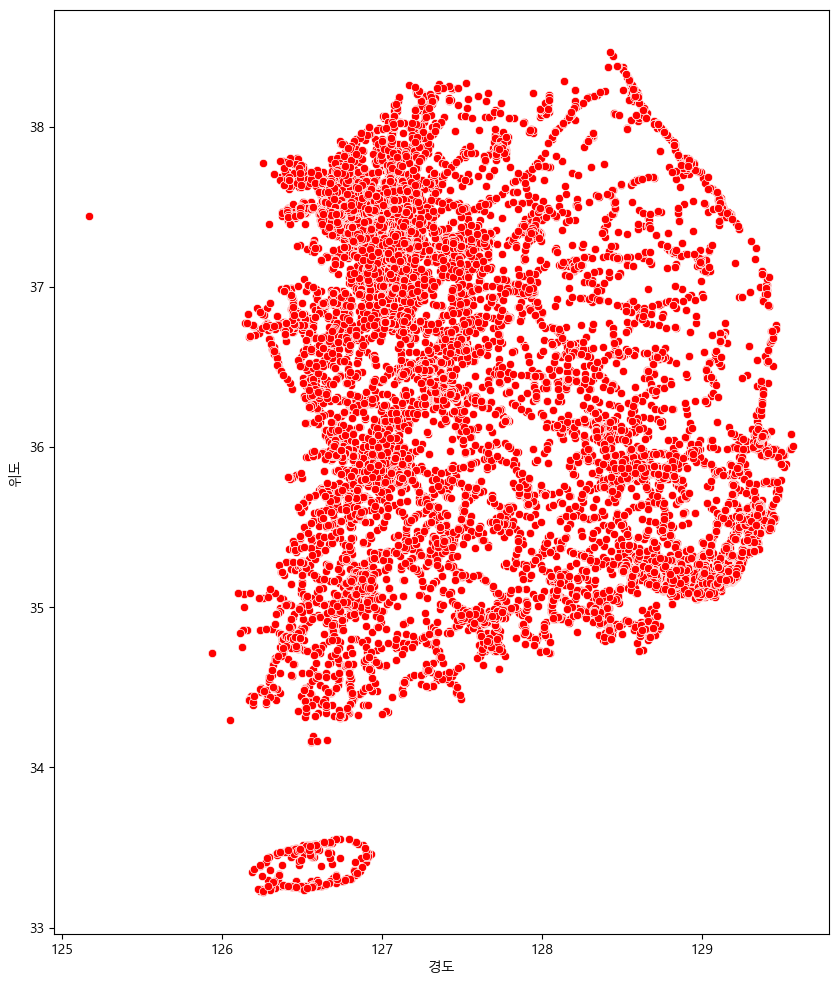

In [15]:
# 단속카메라 데이터 이상치 제거하기: 경도가 135 초과인 데이터 제거하고 확인하기
camera = camera.drop(camera[camera['경도'] > 135].index).reset_index(drop=True)
plt.figure(figsize=(10, 12))
sns.scatterplot(camera, x='경도', y='위도', color='red')

<Axes: xlabel='경도', ylabel='위도'>

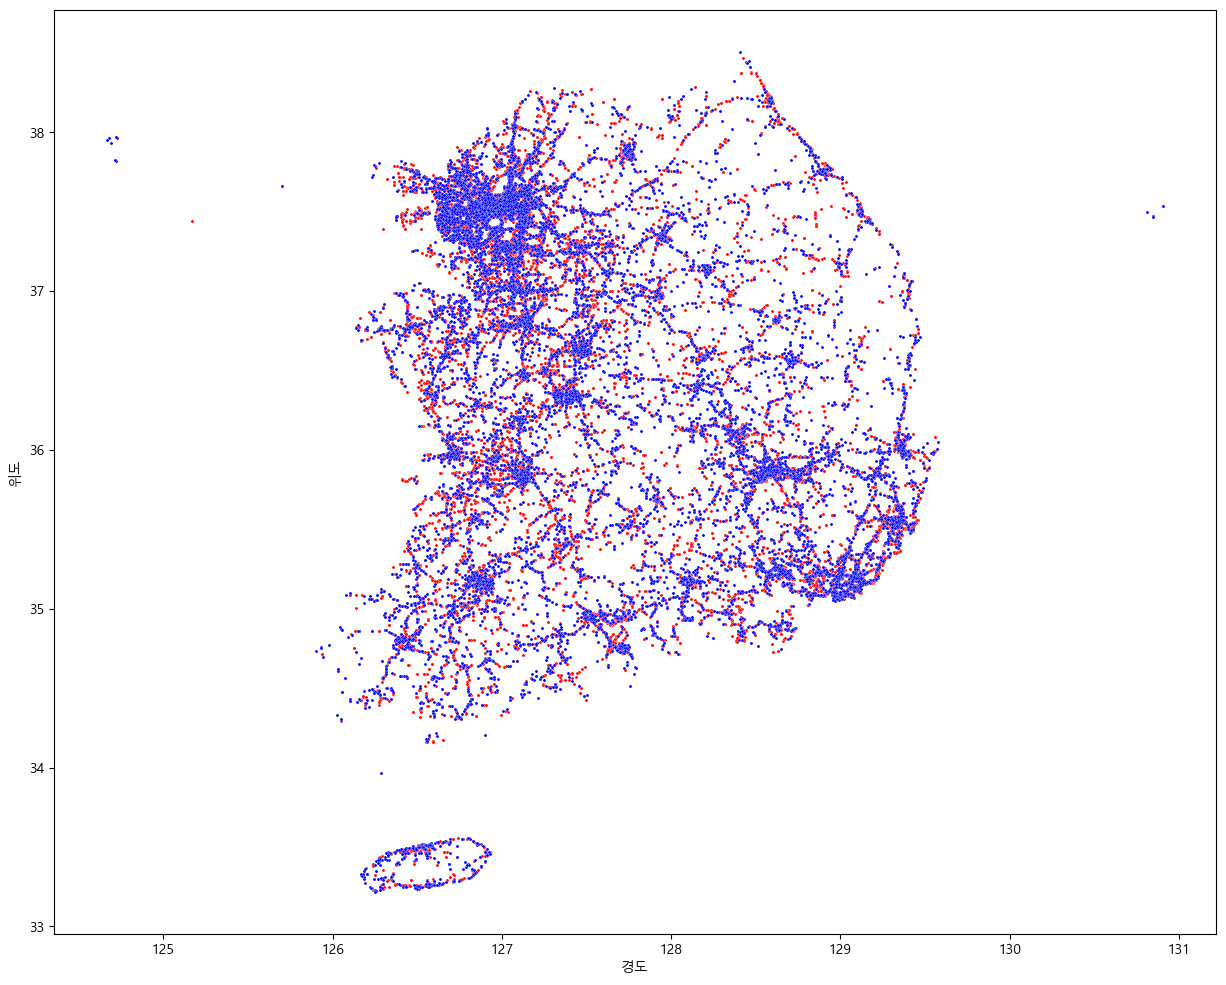

In [16]:
# 교통사고 데이터, 단속카메라 데이터 확인하기
plt.figure(figsize=(15, 12))
sns.scatterplot(camera, x='경도', y='위도', color='red', s=5)
sns.scatterplot(accident, x='경도', y='위도', color='blue', s=5)

<Axes: xlabel='경도', ylabel='위도'>

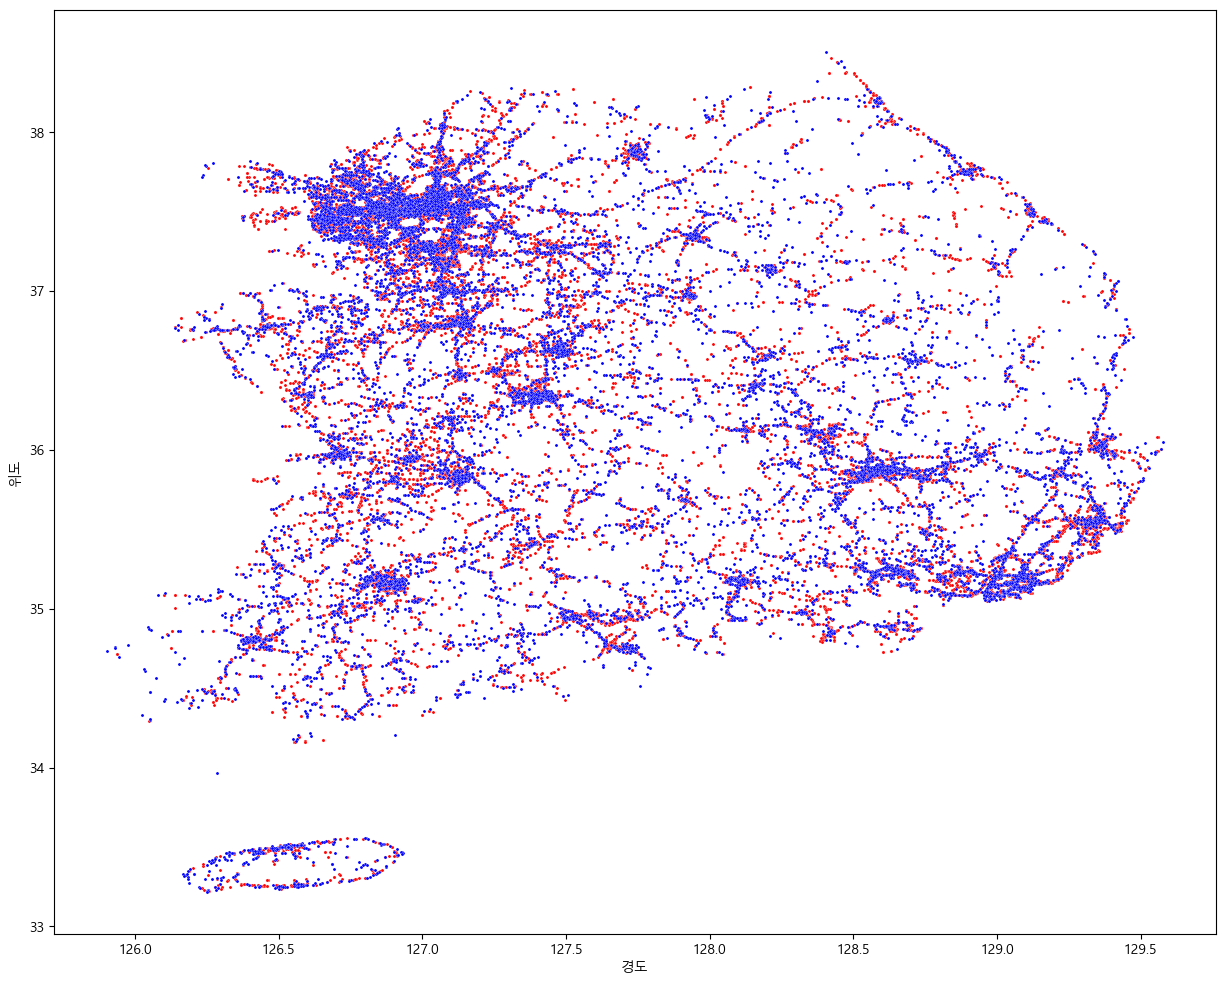

In [17]:
# 멀리 있는 도서지방 제거하기
accident = accident.drop(accident[accident['경도'] > 130].index)
accident = accident.drop(accident[accident['경도'] < 125.8].index)
accident = accident.reset_index(drop=True)

camera = camera.drop(camera[camera['경도'] > 135].index)
camera = camera.drop(camera[camera['경도'] < 125.8].index)
camera = camera.reset_index(drop=True)

# 2024년 설치 카메라 제외하기 (사고데이터 2023년 까지)
camera = camera.drop(camera[camera['설치연도']==2024].index)
camera = camera.reset_index(drop=True)

# 제거후 데이터 확인하기
plt.figure(figsize=(15, 12))
sns.scatterplot(camera, x='경도', y='위도', color='red', s=5)
sns.scatterplot(accident, x='경도', y='위도', color='blue', s=5)

In [18]:
########## 학교, 전광판 데이터 전처리 ##########
school = pd.read_csv('data/rawdata/재단법인한국지방교육행정연구재단_초중등학교위치.csv')
sign = pd.read_csv('data/rawdata/전국가변전광표지판_안내전광판_표준데이터.csv', encoding='cp949')

In [19]:
# 위도, 경도 컬럼만 추출
school = school[['위도', '경도']]
sign = sign[['위도', '경도']]

In [20]:
# 결측치 확인
school.isna().sum()

위도    0
경도    0
dtype: int64

In [21]:
sign.isna().sum()

위도    0
경도    0
dtype: int64

In [22]:
########## 머신러닝용 전처리 ##########

In [23]:
# 위도, 경도 데이터로 반경 이내 해당하는 수를 count하는 함수 정의하기

@jit
def count_function(coord1, coord2, radius=0.5) :
    R = 6371.0
    count_data = []
    for (lat1, lon1) in coord1 :
        count = 0
        for (lat2, lon2) in coord2 :
            dx = (lon2 - lon1) * math.cos((lat1 + lat2) / 2)
            dy = lat2 - lat1
            distance = R * math.sqrt(dx**2 + dy**2)
            if distance <= radius :
              count += 1
        count_data.append(count)
    return count_data

In [24]:
# 함수를 이용하여 파생 칼럼 추가하기
camera_coord = list(zip(camera['위도'].apply(math.radians), camera['경도'].apply(math.radians)))
accident_coord = list(zip(accident['위도'].apply(math.radians), accident['경도'].apply(math.radians)))
school_coord = list(zip(school['위도'].apply(math.radians), school['경도'].apply(math.radians)))
sign_coord = list(zip(sign['위도'].apply(math.radians), sign['경도'].apply(math.radians)))

accident['반경500m카메라수'] = count_function(accident_coord, camera_coord, radius=0.5)
accident['반경500m학교수'] = count_function(accident_coord, school_coord, radius=0.5)
accident['반경500m전광판수'] = count_function(accident_coord, sign_coord, radius=0.5)
accident['반경500m사고건수'] = count_function(accident_coord, accident_coord, radius=0.5)
accident['반경500m사고건수'] = accident['반경500m사고건수'] - 1          # 해당 사고 제외

In [25]:
display(accident[['반경500m카메라수']][:10])

,반경500m카메라수
0,9
1,10
2,0
3,6
4,0
5,0
6,6
7,11
8,0
9,0


In [26]:
accident.info()
accident.to_csv('data/accident_df.csv', encoding='cp949', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14146 entries, 0 to 14145
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   발생년         14146 non-null  int64  
 1   발생월         14146 non-null  int64  
 2   발생일         14146 non-null  int64  
 3   발생시         14146 non-null  int64  
 4   주야          14146 non-null  object 
 5   요일          14146 non-null  object 
 6   발생지시도       14146 non-null  object 
 7   사고유형_대분류    14146 non-null  object 
 8   가해자법규위반     14146 non-null  object 
 9   도로형태_대분류    14146 non-null  object 
 10  가해자_당사자종별   14146 non-null  object 
 11  피해자_당사자종별   14146 non-null  object 
 12  경도          14146 non-null  float64
 13  위도          14146 non-null  float64
 14  사상자수        14146 non-null  float64
 15  반경500m카메라수  14146 non-null  int64  
 16  반경500m학교수   14146 non-null  int64  
 17  반경500m전광판수  14146 non-null  int64  
 18  반경500m사고건수  14146 non-null  int64  
dtypes: float64(3), int64(8), 

In [27]:
# 범주형 컬럼 One-Hot Encoding
accident['주야'] = accident['주야'].apply(lambda x : 1 if x=='주' else 0)

In [28]:
days = pd.get_dummies(accident['요일'])

district = pd.get_dummies(accident['발생지시도'])

classification_large = pd.get_dummies(accident['사고유형_대분류'])
classification_large.rename(columns={'철길건널목': '사고유형철길건널목'}, inplace=True)

violation = pd.get_dummies(accident['가해자법규위반'])
violation.rename(columns={'교차로 통행방법 위반': '교차로통행방법위반', '기타': '가해자법규위반기타',
                          '보행자 보호의무 위반': '보행자보호의무위반', '안전거리 미확보': '안전거리미확보',
                          '안전운전 의무 불이행': '안전운전의무불이행', '중앙선 침범': '중앙선침범'}, inplace=True)

classification_road = pd.get_dummies(accident['도로형태_대분류'])
classification_road.rename(columns={'기타': '도로형태기타', '철길건널목': '도로형태철길건널목'}, inplace=True)

attacker = pd.get_dummies(accident['가해자_당사자종별'])
attacker.columns=['가해자승용차', '가해자화물차', '가해자이륜차', '가해자승합차', '가해자자전거', '가해자건설기계', '가해자농기계',
                  '가해자원동기장치자전거', '가해자특수차', '가해자사륜오토바이ATV', '가해자개인형이동장치PM', 
                  '가해자개인형이동수단PM', '가해자기타', '가해자불명']

victim = pd.get_dummies(accident['피해자_당사자종별'])
victim.columns=['피해자개인형이동수단PM', '피해자개인형이동장치PM', '피해자건설기계', '피해자기타', '피해자농기계',
                '피해자보행자', '피해자불명', '피해자사륜오토바이ATV', '피해자승용차', '피해자승합차', '피해자없음',
                '피해자원동기장치자전거', '피해자이륜차', '피해자자전거', '피해자특수차', '피해자화물차']

accident = accident[['주야', '반경500m카메라수', '반경500m학교수', '반경500m전광판수', '반경500m사고건수']]
accident = pd.concat([days, district, classification_large, classification_road, attacker, victim, accident], axis=1)

In [29]:
# 연속형 컬럼 MinMaxScaling
scaler = MinMaxScaler(feature_range=(0, 1))
accident['반경500m카메라수'] = scaler.fit_transform(accident[['반경500m카메라수']])
accident['반경500m학교수'] = scaler.fit_transform(accident[['반경500m학교수']])
accident['반경500m전광판수'] = scaler.fit_transform(accident[['반경500m전광판수']])

In [30]:
pd.set_option('display.max_columns', None)
display(accident.head())

,금,목,수,월,일,토,화,강원,경기,경남,경북,광주,대구,대전,부산,서울,세종,울산,인천,전남,전북,제주,충남,충북,차대사람,차대차,차량단독,사고유형철길건널목,교차로,도로형태기타,단일로,불명,도로형태철길건널목,가해자승용차,가해자화물차,가해자이륜차,가해자승합차,가해자자전거,가해자건설기계,가해자농기계,가해자원동기장치자전거,가해자특수차,가해자사륜오토바이ATV,가해자개인형이동장치PM,가해자개인형이동수단PM,가해자기타,가해자불명,피해자개인형이동수단PM,피해자개인형이동장치PM,피해자건설기계,피해자기타,피해자농기계,피해자보행자,피해자불명,피해자사륜오토바이ATV,피해자승용차,피해자승합차,피해자없음,피해자원동기장치자전거,피해자이륜차,피해자자전거,피해자특수차,피해자화물차,주야,반경500m카메라수,반경500m학교수,반경500m전광판수,반경500m사고건수
0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0,0.111111,0.1,0.0,1
1,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0,0.123457,0.4,0.0,1
2,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,1,0.000000,0.0,0.0,0
3,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0,0.074074,0.0,0.0,2
4,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0,0.000000,0.0,0.0,0


In [40]:
print(accident.columns)

Index(['금', '목', '수', '월', '일', '토', '화', '강원', '경기', '경남', '경북', '광주', '대구',
       '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북',
       '차대사람', '차대차', '차량단독', '사고유형철길건널목', '교차로', '도로형태기타', '단일로', '불명',
       '도로형태철길건널목', '가해자승용차', '가해자화물차', '가해자이륜차', '가해자승합차', '가해자자전거',
       '가해자건설기계', '가해자농기계', '가해자원동기장치자전거', '가해자특수차', '가해자사륜오토바이ATV',
       '가해자개인형이동장치PM', '가해자개인형이동수단PM', '가해자기타', '가해자불명', '피해자개인형이동수단PM',
       '피해자개인형이동장치PM', '피해자건설기계', '피해자기타', '피해자농기계', '피해자보행자', '피해자불명',
       '피해자사륜오토바이ATV', '피해자승용차', '피해자승합차', '피해자없음', '피해자원동기장치자전거', '피해자이륜차',
       '피해자자전거', '피해자특수차', '피해자화물차', '주야', '반경500m카메라수', '반경500m학교수',
       '반경500m전광판수', '반경500m사고건수'],
      dtype='object')


In [ ]:
# 새로 추가된 코드(시설합 추가)
# [Feature Engineering 1] 시설합(카메라+학교+전광판)
accident["시설합"] = (
    accident["반경500m카메라수"] +
    accident["반경500m학교수"] +
    accident["반경500m전광판수"]
)

# 잘 들어갔는지 5줄 확인
print(accident[["반경500m카메라수", "반경500m학교수", "반경500m전광판수", "시설합"]].head())



   반경500m카메라수  반경500m학교수  반경500m전광판수       시설합
0    0.111111        0.1         0.0  0.211111
1    0.123457        0.4         0.0  0.523457
2    0.000000        0.0         0.0  0.000000
3    0.074074        0.0         0.0  0.074074
4    0.000000        0.0         0.0  0.000000


In [47]:
accident.drop(columns=["시설합"], inplace=True)

In [50]:
# [Feature Engineering 3] 사고 밀도 추가
accident["사고밀도"] = accident["반경500m사고건수"] / 500

print(accident[["반경500m사고건수", "사고밀도"]].head())


   반경500m사고건수   사고밀도
0           1  0.002
1           1  0.002
2           0  0.000
3           2  0.004
4           0  0.000


In [51]:
accident.drop(columns=["사고밀도"], inplace=True)

In [54]:
# [Feature Engineering] 주야 × 교차로

accident["야간_교차로"] = accident["주야"] * accident["교차로"]

print(accident[["주야", "교차로", "야간_교차로"]].head())

   주야    교차로  야간_교차로
0   0   True       0
1   0  False       0
2   1   True       1
3   0   True       0
4   0  False       0


In [57]:
accident.drop(columns=["야간_교차로"], inplace=True)

In [60]:
########## modeling ##########
# 독립변수, 종속변수로 분리
X = accident.drop(columns=['반경500m사고건수'], axis=1)
y = accident['반경500m사고건수']

# train, test dataset으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11316, 68) (2830, 68) (11316,) (2830,)


In [ ]:
#%pip install xgboost --upgrade

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
    --------------------------------------- 2.1/101.7 MB 11.7 MB/s eta 0:00:09
   - -------------------------------------- 4.5/101.7 MB 11.2 MB/s eta 0:00:09
   -- ------------------------------------- 7.1/101.7 MB 11.5 MB/s eta 0:00:09
   --- ------------------------------------ 9.7/101.7 MB 11.6 MB/s eta 0:00:08
   ---- ----------------------------------- 12.1/101.7 MB 11.6 MB/s eta 0:00:08
   ----- ---------------------------------- 14.7/101.7 MB 11.7 MB/s eta 0:00:08
   ------ --------------------------------- 17.3/101.7 MB 11.7 MB/s eta 0:00:08
   ------- -------------------------------- 19.7/101.7 MB 11.7 MB/s eta 0:00:08
   -------- ------------------------------- 22.3/101.7 MB 11.7 MB/s eta 0:00:07
   --------- ------------------------------ 24.9/101.7 MB 11.8 MB/s eta 0:00:07
   ---------- ----------------------------- 27.3/101.7 MB 11.8 MB/s eta 0:00:07
   ----------- ---------------------------- 29.9/101.


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# 모델 비교

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

models = {
    "LinearRegression": LinearRegression(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor()
}

print("=== Model Comparison ===")
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    results[name] = mae
    print(f"{name}: {mae}")

=== Model Comparison ===
LinearRegression: 0.8695494772486521
XGBoost: 0.8728445172309875
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 11316, number of used features: 60
[LightGBM] [Info] Start training from score 1.095175
LightGBM: 0.8485978819945201


In [61]:
# 비교해보니 성능좋게나온 LightGBM을 baseline으로 함
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

print("=== Baseline (LightGBM default) ===")
baseline_model = LGBMRegressor(random_state=42)   # 파라미터 거의 기본값
baseline_model.fit(X_train, y_train)

baseline_pred = baseline_model.predict(X_test)
baseline_mae = mean_absolute_error(y_test, baseline_pred)

print("Baseline MAE:", baseline_mae)

=== Baseline (LightGBM default) ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 11316, number of used features: 60
[LightGBM] [Info] Start training from score 1.095175
Baseline MAE: 0.8485978819945201


In [62]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import numpy as np

print("=== KFold CV ===")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []

for train_idx, val_idx in kf.split(X):
    X_train_cv, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = LGBMRegressor(random_state=42)
    model.fit(X_train_cv, y_train_cv)
    
    pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, pred)
    
    mae_list.append(mae)

print("MAE 리스트:", mae_list)
print("평균 MAE:", np.mean(mae_list))

=== KFold CV ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 11316, number of used features: 60
[LightGBM] [Info] Start training from score 1.083245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 11317, number of used features: 60
[LightGBM] [Info] Start training from score 1.076699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

In [ ]:
import pandas as pd

# 학습된 모델 하나 사용 (마지막 model) Feature Importance 확인
# 상위 20개의 feature를 가져옴 (쓸데없는 feature 제거)
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

print(feature_importance.head(20))

         feature  importance
64    반경500m카메라수         682
65     반경500m학교수         381
66    반경500m전광판수         165
63            주야         127
28           교차로         113
40   가해자원동기장치자전거         107
15            서울         104
30           단일로          92
24          차대사람          86
8             경기          71
25           차대차          51
14            부산          50
6              화          46
0              금          44
46         가해자불명          42
43  가해자개인형이동장치PM          42
3              월          40
18            인천          35
41        가해자특수차          34
5              토          34


In [66]:
# [STEP 1] 중요도 기반 feature 선택 리스트 만들기
# 방금 만든 feature_importance 데이터프레임을 그대로 사용

threshold = 30  # 일단 30으로 시작 (너가 준 상위 중요도 보면 적당함)

selected_features = feature_importance[feature_importance["importance"] > threshold]["feature"].tolist()

print("선택된 feature 개수:", len(selected_features))
print("선택된 feature 목록:")
print(selected_features)

선택된 feature 개수: 24
선택된 feature 목록:
['반경500m카메라수', '반경500m학교수', '반경500m전광판수', '주야', '교차로', '가해자원동기장치자전거', '서울', '단일로', '차대사람', '경기', '차대차', '부산', '화', '금', '가해자불명', '가해자개인형이동장치PM', '월', '인천', '가해자특수차', '토', '전남', '대구', '일', '목']


In [67]:
# 선택된 feature로 데이터 다시 만들기
# [STEP 2] 선택된 feature만 사용해서 X 다시 만들기
X_selected = X[selected_features]

print("기존 feature 개수:", X.shape[1])
print("선택된 feature 개수:", X_selected.shape[1])

기존 feature 개수: 68
선택된 feature 개수: 24


In [68]:
# [STEP 3] 선택된 feature로 KFold 다시 검증

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import numpy as np

print("=== KFold CV (Selected Features) ===")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []

for train_idx, val_idx in kf.split(X_selected):
    X_train_cv = X_selected.iloc[train_idx]
    X_val = X_selected.iloc[val_idx]
    y_train_cv = y.iloc[train_idx]
    y_val = y.iloc[val_idx]
    
    model = LGBMRegressor(random_state=42)
    model.fit(X_train_cv, y_train_cv)
    
    pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, pred)
    
    mae_list.append(mae)

print("MAE 리스트:", mae_list)
print("평균 MAE:", np.mean(mae_list))

=== KFold CV (Selected Features) ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99
[LightGBM] [Info] Number of data points in the train set: 11316, number of used features: 24
[LightGBM] [Info] Start training from score 1.083245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 11317, number of used features: 24
[LightGBM] [Info] Start training from score 1.076699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the ove

In [69]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

print("=== GridSearch ===")

param_grid = {
    "n_estimators": [300, 500],
    "learning_rate": [0.05, 0.1],
    "num_leaves": [31, 50],
    "max_depth": [-1, 5]
}

lgbm = LGBMRegressor(random_state=42)

grid = GridSearchCV(
    lgbm,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X, y)

print("Best Params:", grid.best_params_)
print("Best MAE:", -grid.best_score_)

=== GridSearch ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 14146, number of used features: 61
[LightGBM] [Info] Start training from score 1.080023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
# LightGBM 튜닝해보기
# 성능 오히려 떨어짐
print("\n=== Improved Model (Tuned LightGBM v2) ===")

tuned_model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

tuned_model.fit(X_train, y_train)

tuned_pred = tuned_model.predict(X_test)
tuned_mae = mean_absolute_error(y_test, tuned_pred)

print("Tuned MAE:", tuned_mae)


=== Improved Model (Tuned LightGBM v2) ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 11316, number of used features: 60
[LightGBM] [Info] Start training from score 1.095175
Tuned MAE: 0.8686317759534126


In [1116]:
lgbm_model = LGBMRegressor(n_estimators=1000, learning_rate=0.1, max_depth=4, min_child_weight=1, colsample_bytree=0.3)
lgbm_model.fit(X_train, y_train)

# 예측하기
y_pred = lgbm_model.predict(X_test, verbose=0)

# 정확도 측정
mae = mean_absolute_error(y_test, y_pred)
print(f'mae: {mae}')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

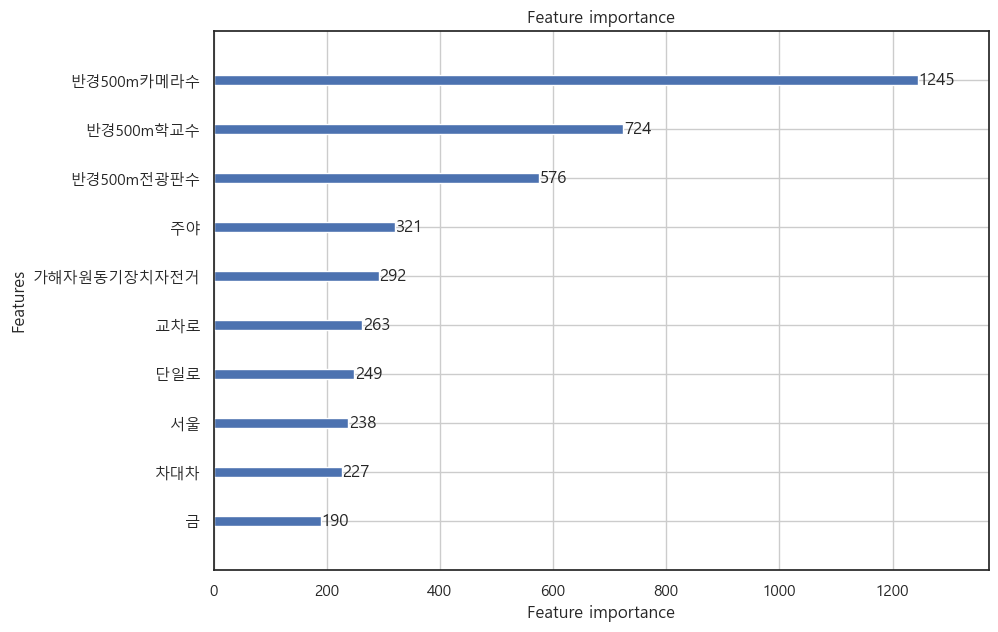

In [1117]:
# 주요 feature 시각화하기
fig, ax = plt.subplots(figsize=(10, 7))
plot_importance(lgbm_model, ax=ax, max_num_features=10)

<Axes: >

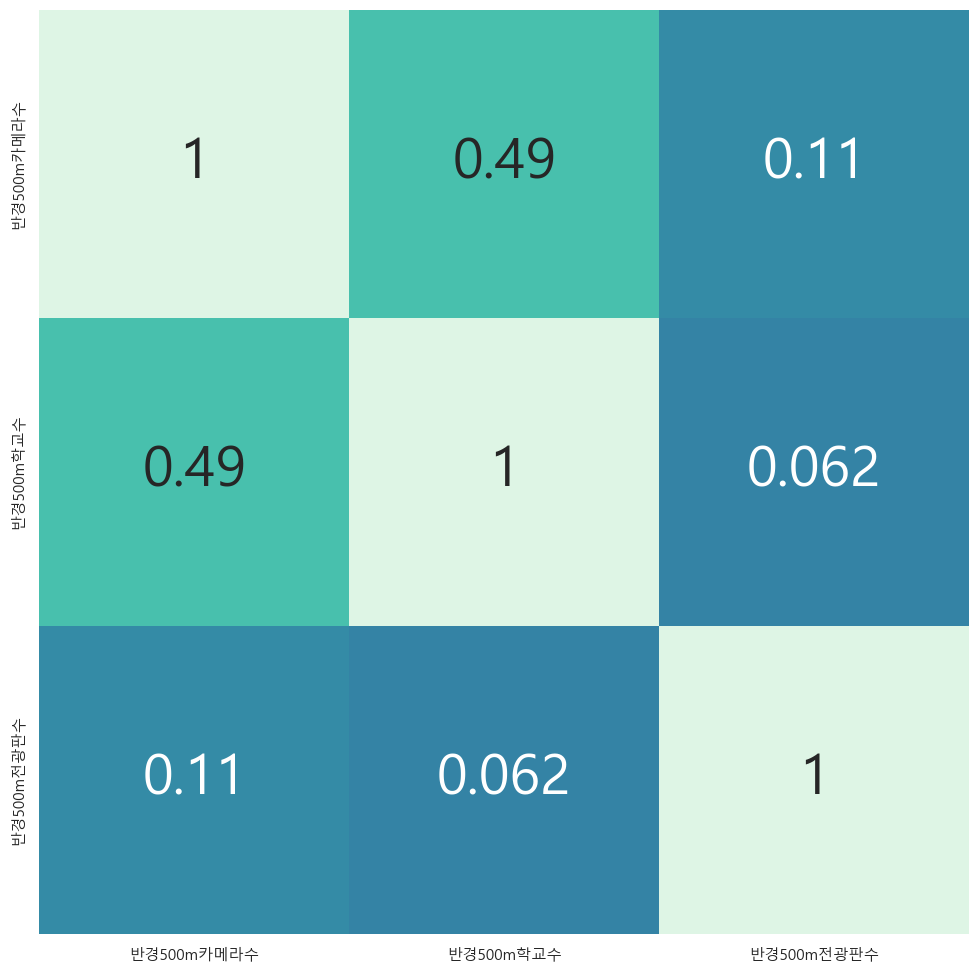

In [1118]:
corr = accident[['반경500m카메라수', '반경500m학교수', '반경500m전광판수']]
corr_df = corr.corr()

#히트맵 시각화

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')
sns.heatmap(corr_df, annot = True, cmap = 'mako', cbar=False, vmin = -1, vmax = 1, annot_kws={"size": 40})

In [1119]:
########## 데이터 시각화 ##########
accident = pd.read_csv('data/accident_for_visualization.csv', encoding='cp949')
accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14158 entries, 0 to 14157
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   발생년        14158 non-null  int64  
 1   발생월        14158 non-null  int64  
 2   발생일        14158 non-null  int64  
 3   발생시        14158 non-null  int64  
 4   주야         14158 non-null  object 
 5   요일         14158 non-null  object 
 6   발생지시도      14158 non-null  object 
 7   사고유형_대분류   14158 non-null  object 
 8   가해자법규위반    14158 non-null  object 
 9   도로형태_대분류   14158 non-null  object 
 10  가해자_당사자종별  14158 non-null  object 
 11  피해자_당사자종별  14158 non-null  object 
 12  경도         14158 non-null  float64
 13  위도         14158 non-null  float64
 14  사상자수       14158 non-null  float64
dtypes: float64(3), int64(4), object(8)
memory usage: 1.6+ MB


In [1120]:
accident_vis['사상자수'] = accident_vis['사상자수'].astype('int64')

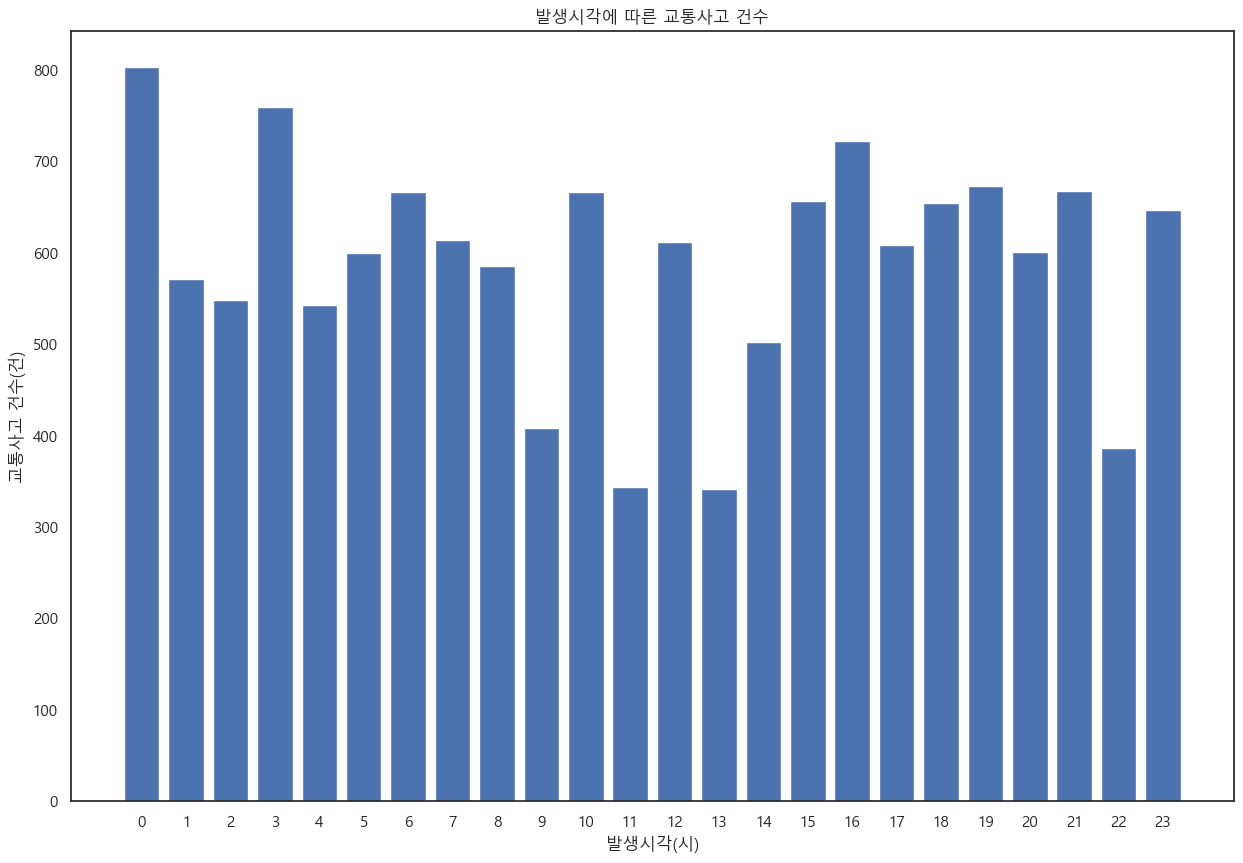

In [1121]:
# 발생시에 따른 교통사고 건수
plt.figure(figsize=(15, 10))
plt.bar(accident['발생시'].unique(), accident['발생시'].value_counts())
plt.xticks(accident['발생시'].unique())
plt.xlabel('발생시각(시)')
plt.ylabel('교통사고 건수(건)')
plt.title('발생시각에 따른 교통사고 건수')
plt.show()

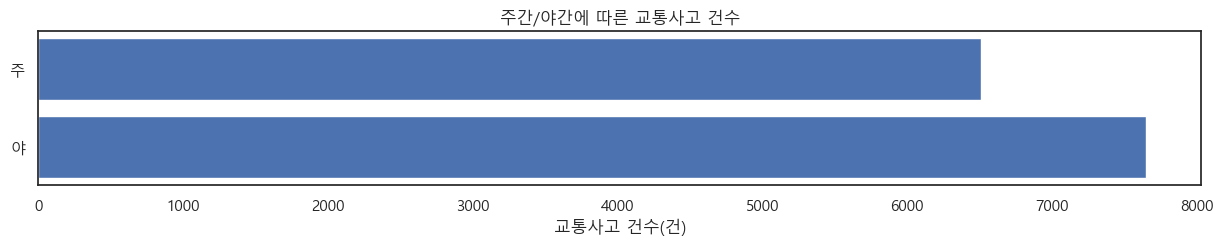

In [1122]:
# 주야에 따른 교통사고 건수
plt.figure(figsize=(15, 2))
plt.barh(accident['주야'].unique(), accident['주야'].value_counts())
plt.xlabel('교통사고 건수(건)')
plt.title('주간/야간에 따른 교통사고 건수')
plt.show()

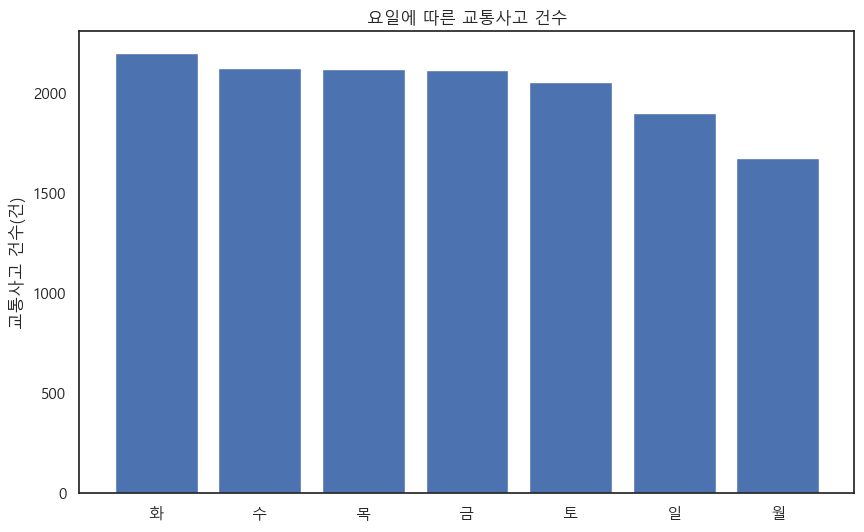

In [1123]:
# 요일에 따른 교통사고 건수
plt.figure(figsize=(10, 6))
plt.bar(accident['요일'].unique(), accident['요일'].value_counts())
plt.ylabel('교통사고 건수(건)')
plt.title('요일에 따른 교통사고 건수')
plt.show()

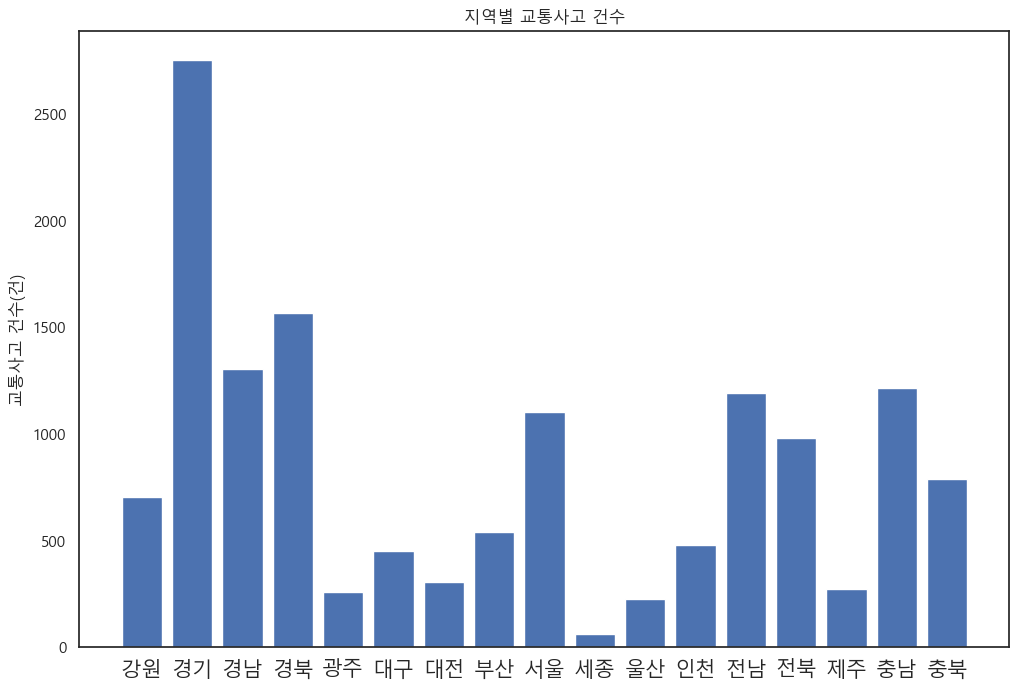

In [1124]:
# 지역별 교통사고 건수
district = accident.groupby('발생지시도')['사상자수'].count()
label = district.index
index = np.arange(len(label))

plt.figure(figsize=(12, 8))
plt.bar(index, district)
plt.xticks(index, label, fontsize=15)
plt.ylabel('교통사고 건수(건)')
plt.title('지역별 교통사고 건수')
plt.show()

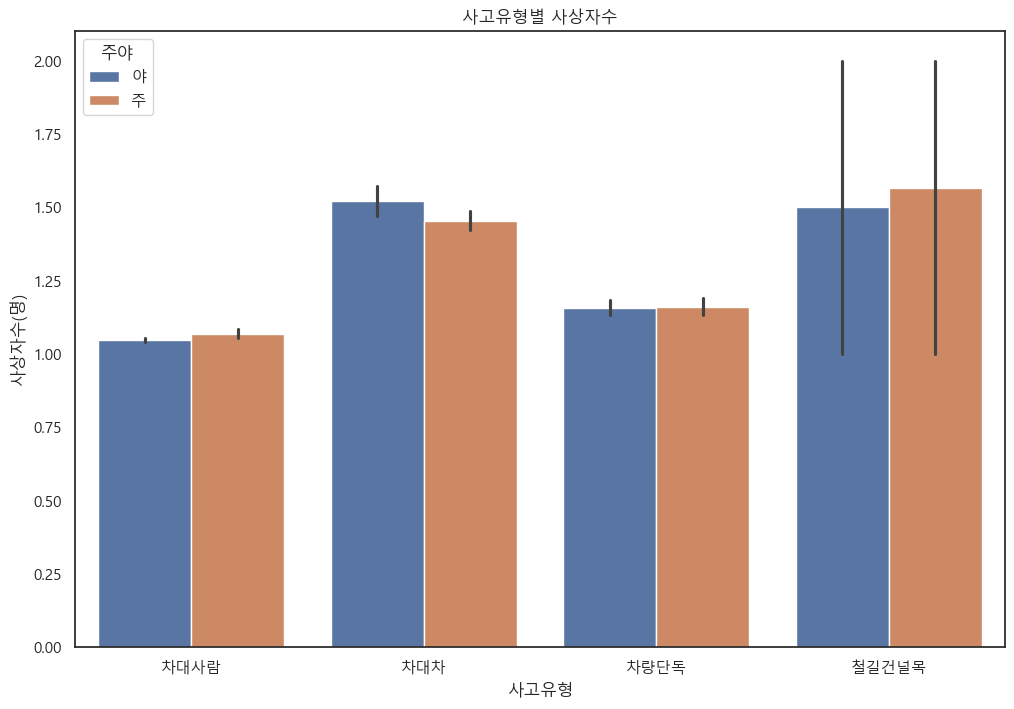

In [1125]:
# 사고유형별 사상자수 분포
plt.figure(figsize=(12, 8))
sns.barplot(x=accident['사고유형_대분류'], y=accident['사상자수'], hue='주야', data=accident)
plt.xlabel('사고유형')
plt.ylabel('사상자수(명)')
plt.title('사고유형별 사상자수')
plt.show()

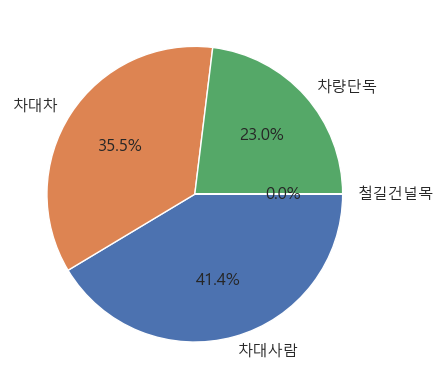

In [1126]:
# 사고유형 비율 pie plot으로
data_list = accident['사고유형_대분류'].value_counts().to_list()
plt.pie(
  data_list, labels = ['차대사람', '차대차', '차량단독', '철길건널목'], autopct='%.1f%%', counterclock=False
)
plt.show()

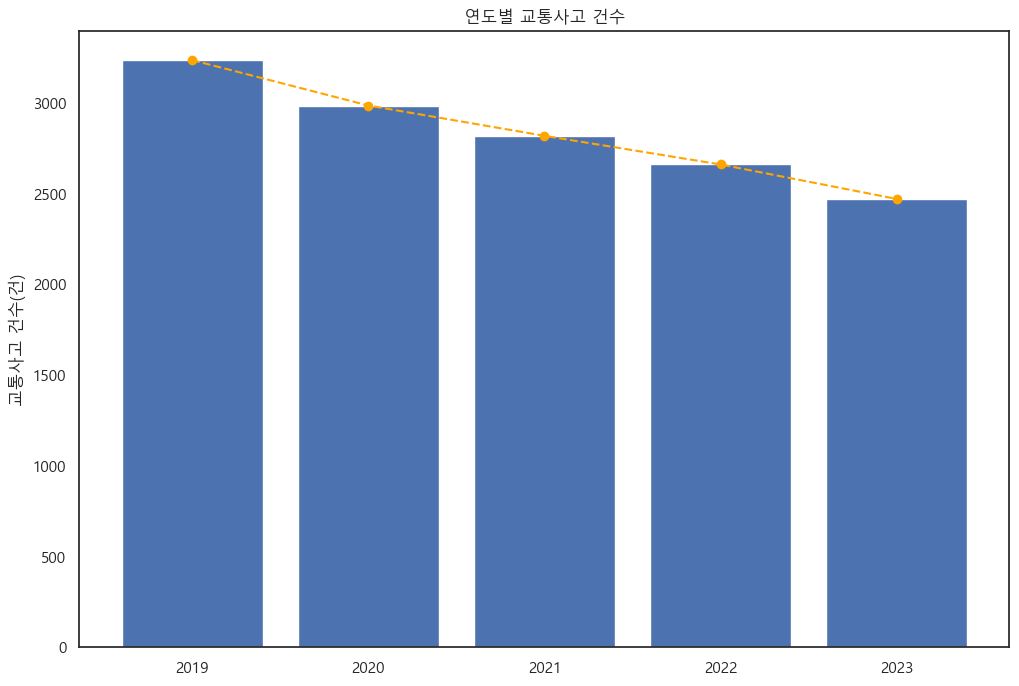

In [1127]:
# 발생년별 교통사고 건수
year = accident['발생년']

# 사고유형별 사상자수 분포
plt.figure(figsize=(12, 8))
plt.bar(accident['발생년'].unique(), accident['발생년'].value_counts())
plt.plot(accident['발생년'].unique(), accident['발생년'].value_counts(), color='orange',linestyle='--',marker='o')
plt.ylabel('교통사고 건수(건)')
plt.title('연도별 교통사고 건수')
plt.show()

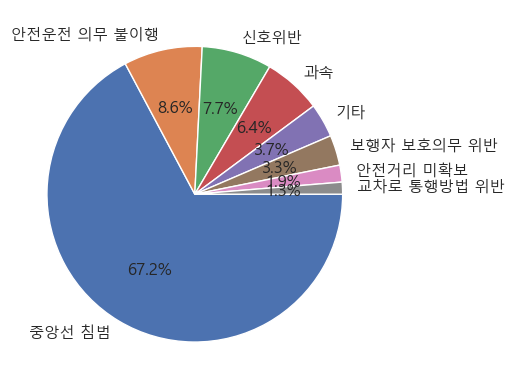

In [1128]:
# 가해자 법규 위반 종류 별 교통사고 건수
data_list = accident['가해자법규위반'].value_counts().to_list()
label = accident['가해자법규위반'].unique()
plt.pie(
  data_list, labels = label, autopct='%.1f%%', counterclock=False
)
plt.show()

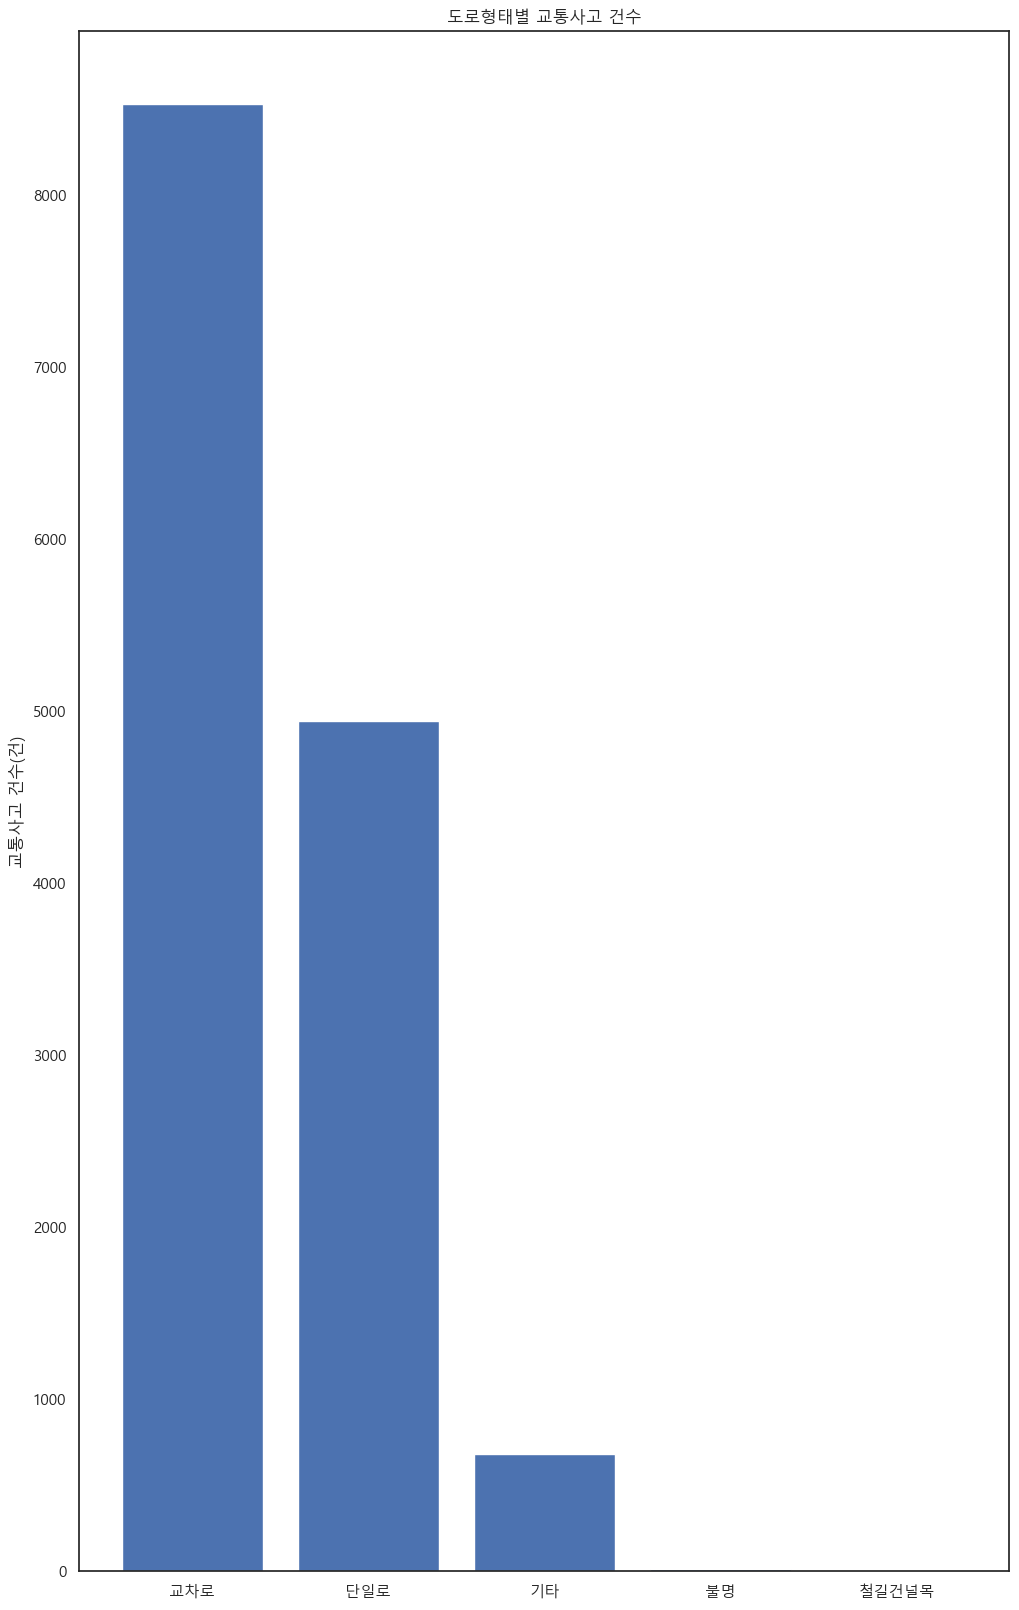

In [1129]:
# 도로형태_대분류 교통사고 건수
road_label = accident['도로형태_대분류'].unique()
road_count = accident['도로형태_대분류'].value_counts()

plt.figure(figsize=(12, 20))
plt.bar(road_label, road_count)
plt.ylabel('교통사고 건수(건)')
plt.title('도로형태별 교통사고 건수')
plt.show()

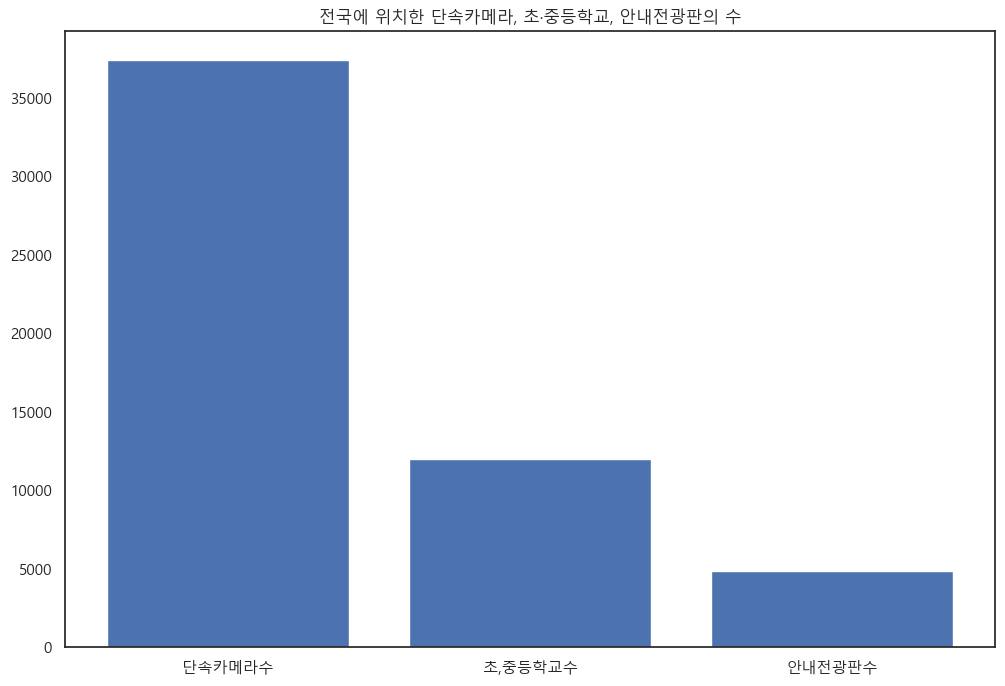

In [1130]:
# 단속카메라, 학교, 전광판 수 시각화
data_list = [camera['위도'].count(), school['위도'].count(), sign['위도'].count()]
label = ['단속카메라수', '초,중등학교수', '안내전광판수']

# 사고유형별 사상자수 분포
plt.figure(figsize=(12, 8))
plt.bar(label, data_list)
plt.title('전국에 위치한 단속카메라, 초·중등학교, 안내전광판의 수')
plt.show()

In [1131]:
########## 사고다발구역 연관 시각화 ##########

In [1132]:
# 사고다발구역 데이터 전처리
area_district = pd.read_csv('data/rawdata/도로교통공단_교통사고다발지역_20240909.csv')
area_district.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14478 entries, 0 to 14477
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   사고지역관리번호     14478 non-null  int64  
 1   사고연도         14478 non-null  int64  
 2   사고유형구분       14478 non-null  object 
 3   위치코드         14478 non-null  int64  
 4   사고다발지역시도시군구  14478 non-null  object 
 5   사고지역위치명      14478 non-null  object 
 6   사고건수         14478 non-null  int64  
 7   사상자수         14478 non-null  int64  
 8   사망자수         14478 non-null  int64  
 9   중상자수         14478 non-null  int64  
 10  경상자수         14478 non-null  int64  
 11  부상신고자수       14478 non-null  int64  
 12  위도           14478 non-null  float64
 13  경도           14478 non-null  float64
 14  사고다발지역폴리곤정보  14478 non-null  object 
 15  데이터기준일자      14478 non-null  object 
dtypes: float64(2), int64(9), object(5)
memory usage: 1.8+ MB


In [1133]:
area_district = area_district[['사고다발지역폴리곤정보']]
area_district

,사고다발지역폴리곤정보
0,"{type:Polygon,coordinates:[[[127.002009,37.590..."
1,"{type:Polygon,coordinates:[[[127.0381354,37.59..."
2,"{type:Polygon,coordinates:[[[127.0169658,37.59..."
3,"{type:Polygon,coordinates:[[[127.0619982,37.61..."
4,"{type:Polygon,coordinates:[[[127.0268336,37.65..."
...,...
14473,"{type:Polygon,coordinates:[[[128.60669404,34.8..."
14474,"{type:Polygon,coordinates:[[[126.68290339,35.9..."
14475,"{type:Polygon,coordinates:[[[126.71726006,35.9..."
14476,"{type:Polygon,coordinates:[[[126.7386179,35.96..."


In [ ]:
# 문자열을 polygon 좌표 list로 변환하기
f = lambda str : literal_eval(re.search(r'\[.*\]', str).group())[0]
area_district['사고다발지역폴리곤정보'] = area_district['사고다발지역폴리곤정보'].apply(f)
area_district

In [ ]:
# shapely module에서 사용할 polygon 객체 list 만들기
poly_list = area_district['사고다발지역폴리곤정보'].to_list()
# 맨 안쪽 list를 tuple로 변환
for i in range(len(poly_list)) :
    for j in range(len(poly_list[i])) :
        poly_list[i][j] = (poly_list[i][j][0], poly_list[i][j][1])

poly_list

In [ ]:
# 각 polygon data로 Polygon 객체 생성후 GeoDataFrame으로 만들기
from shapely.geometry import Polygon

polygons = []

for coord in poly_list :
    polygons.append(Polygon(coord))

area_gdf = gpd.GeoDataFrame({'사고다발구역': polygons})
area_gdf = area_gdf.set_geometry('사고다발구역')
area_gdf.set_crs("EPSG:4326", allow_override=True)
area_gdf

In [ ]:
# 모든 polygon 객체를 합집합한 객체 생성
union_area = area_gdf.union_all()

In [ ]:
# 합한 결과를 folium을 통해 map에 표시하기
area_geojson_data = union_area.__geo_interface__
map_center = [36, 128]

map = folium.Map(location=map_center, zoom_start=7)
folium.TileLayer(tiles='CartoDB positron').add_to(map)
folium.GeoJson(area_geojson_data, name="area", color='blue', fill=True, fill_color='blue', fill_opacity=0.2).add_to(map)

In [ ]:
map

In [ ]:
# 5개년 사고 데이터
accident_df = pd.read_csv('data/accident_df.csv', encoding='cp949')
accident_df.info()

In [ ]:
accident_df['반경500m전광판수'].value_counts()

In [ ]:
# 반경 500m 안에 사고건수 3건이상, 카메라 3대이상, 학교 2개이상, 전광판 1개 이상인 지점만 추출
filtered_accident = accident_df[(accident_df['반경500m사고건수'] >= 3) & (accident_df['반경500m카메라수'] >= 3) &\
    (accident_df['반경500m학교수'] >= 2) & (accident_df['반경500m전광판수'] >= 1)]
filtered_accident = \
    filtered_accident[['경도','위도','반경500m사고건수', '반경500m카메라수', '반경500m학교수', '반경500m전광판수']]
filtered_accident.reset_index(drop=True)

In [ ]:
# 각 점의 좌표에 대해 반경 500m인 지점 36각형으로 근사한 Polygon 객체 구하기
@jit
def approx_poly(coord_list, radius=0.5, n_points=36) :
    poly_list = []
    step = 360 / n_points
    
    for (lon, lat) in coord_list :
        km_per_lat = 111.32
        km_per_lon = 111.32 * math.cos(math.radians(lat))
        poly_coords = []
        for i in range(n_points) :
            angle = math.radians(i * step)
            dx = radius / km_per_lon
            dy = radius / km_per_lat
            new_lon = lon + dx * math.cos(angle)
            new_lat = lat + dy * math.sin(angle)

            poly_coords.append((new_lon, new_lat))
            
        poly_list.append(poly_coords)

    return poly_list

In [ ]:
coord_list = list(zip(filtered_accident['경도'], filtered_accident['위도']))
accident_poly_list = approx_poly(coord_list, radius=0.5, n_points=36)

In [ ]:
# 필터링된 사고 지역 data를 GeoDataFrame으로 만들기
accident_polygons = []

for coord in accident_poly_list :
    accident_polygons.append(Polygon(coord))

accident_gdf = gpd.GeoDataFrame({'사고위치': accident_polygons})
accident_gdf = accident_gdf.set_geometry('사고위치')
accident_gdf.set_crs("EPSG:4326", allow_override=True)
accident_gdf

In [ ]:
# 모든 polygon 객체를 합집합한 객체 생성
union_accident = accident_gdf.union_all()

In [ ]:
# 합한 결과를 folium을 통해 map에 표시하기
accident_geojson_data = union_accident.__geo_interface__

folium.GeoJson(accident_geojson_data, name="area", color='red', fill=True, fill_color='red', fill_opacity=0.2).add_to(map)

In [ ]:
map

In [ ]:
# 차집합 구하기
diff = union_accident.difference(union_area)
diff_geojson_data = diff.__geo_interface__
map_center = [36, 128]

map_diff = folium.Map(location=map_center, zoom_start=7)
folium.TileLayer(tiles='CartoDB positron').add_to(map_diff)
folium.GeoJson(diff_geojson_data, name="area", color='red', fill=True, fill_color='red', fill_opacity=0.5).add_to(map_diff)

In [ ]:
map_diff

In [ ]:
# 각 위치에 대해 다발구역 차집합 연산
accident_gdf['사고위치'] = accident_gdf['사고위치'].apply(lambda x : x.difference(union_area))

In [ ]:
# 각 위치를 folium map에 표시하기
map_diff2 = folium.Map(location=map_center, zoom_start=7)
folium.TileLayer(tiles='CartoDB positron').add_to(map_diff2)
for p in accident_gdf['사고위치'] :
    p_geojson_data = p.__geo_interface__
    folium.GeoJson(p_geojson_data, name="area", color='red', popup=p_geojson_data,
                   fill=True, fill_color='red', fill_opacity=0.1).add_to(map_diff2)

In [ ]:
map_diff2